# Model + noise + downsampling workflow

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pyleoclim as pyleo

In [2]:
import paleobeasts as pb

from paleobeasts.signal_models import g24
from paleobeasts.utils import downsample,noise

### First step : Initializing and solving the model

See the Ganopolski2024_demo notebook for details.

In [3]:
A = 25 #Magnitude of forcing in Wm−2
eps = 0.5 #nondimensional magnitude of eccentricity modulation

# initialize the forcing with calc_f
g24_forcing = pb.Forcing(g24.calc_f, params = {'A':A, 'eps':eps})

f1 = -16 #insolation threshold for glacial inception
f2 = 16 #insolation threshold for deglaciation inception
vc = 1.47 #critical ice volume
t1 = 30 #relaxation timescale for glacial inception
t2 = 10 #relaxation timescale for deglaciation

# Initialize the model
model3 = g24.Model3(forcing=g24_forcing, var_name='ice volume', vc=vc, f1=f1, f2=f2, t1=t1, t2=t2)
model3.dfdt = (g24.calc_df)

length = 1200 #length of simulation in kyr
t_i = 0 #start time
t_f = t_i+length #end time
dt=4 #timestep

v_i= 0 #initial ice volume
k_i = 1 #initial state

model3_euler = pb.Solver(model3, method='euler', t_span=(t_i, t_f), y0=[v_i, k_i], kwargs={'dt':dt})
model3_euler.integrate()


/Users/alexjames/GitHub/PaleoBeasts/paleobeasts/signal_models/g24.py:163: RuntimeWarning: invalid value encountered in sqrt
  return 1 + np.sqrt((self.f2 - f) / (self.f2 - self.f1))
/Users/alexjames/GitHub/PaleoBeasts/paleobeasts/signal_models/g24.py:180: RuntimeWarning: invalid value encountered in sqrt
  return 1 - np.sqrt((self.f2 - f) / (self.f2 - self.f1))


Create a basic pyleoclim Series object from the model. Time name and units are arbitrary here (for our purposes anyway).

In [4]:
model_series = pyleo.Series(
    time=model3_euler.solution.t, 
    value=model3_euler.solution.y[:,0], 
    label='ice volume',
    time_name = 'Age',
    time_unit='ka',
    auto_time_params=True)

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

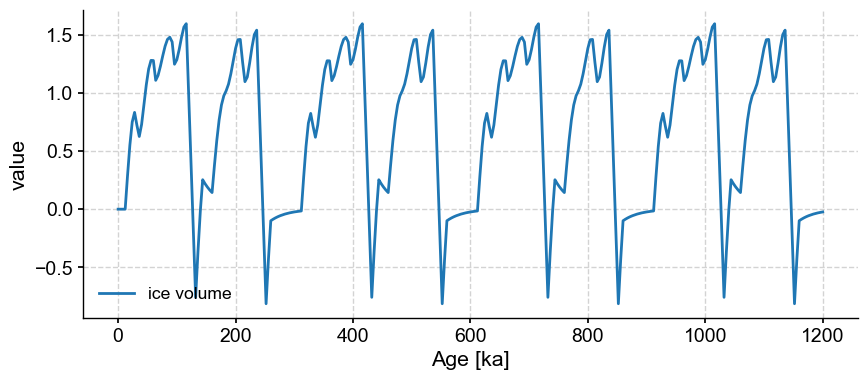

In [5]:
model_series.plot()

Looks good, now lets add some AR(1) noise:

In [10]:
series = model_series.copy()

noise_series = noise.from_param(
    method='uar1',
    noise_param=[5,1],
    time_pattern='specified',
    settings={'time':series.time},
    scale = .5
)

series.value += noise_series.value

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

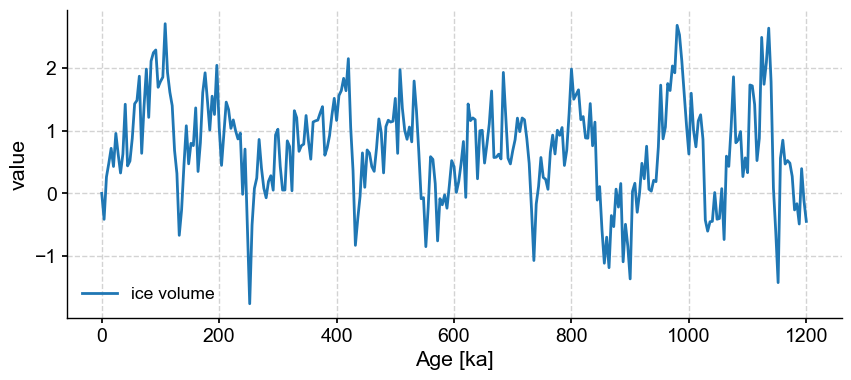

In [14]:
series.plot()

We can go ahead and downsample a bit too:

In [23]:
#Downsampling the data series using the default parameters (method='exponential' and param=1)
downsampled_series = downsample(series,seed=42,method='poisson',param=[.3])

(<Figure size 1000x400 with 1 Axes>, <Axes: xlabel='Age [ka]', ylabel='value'>)

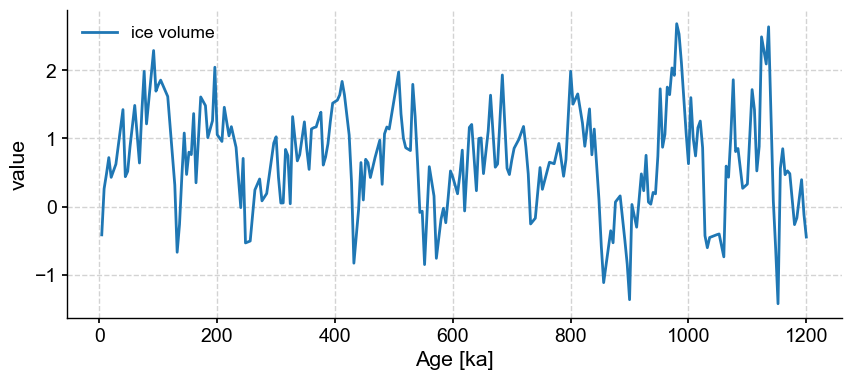

In [24]:
downsampled_series.plot()

Feel free to play around further!